In [1]:
#libraries with ready functions
import numpy as np 
import matplotlib.pyplot as plt
import copy
from ipywidgets import IntProgress
from IPython.display import display
from scipy import interpolate
%matplotlib notebook
import cProfile

from numba import jit

In [2]:
#my functions

#function for calculations acceleration. Tells whether photon far from zone with wessels or not
@jit(nopython=True)
def Far(p, bounds):
    if p[0]>bounds[0]  and p[0]<bounds[1] and p[2]<bounds[3] and p[2]>bounds[2]:
        return False
    else:     
        return True

#distance between photon and particular cylinder in the direction of photon propagation
@jit(nopython=True)
def Cyl_dist(p, x0,z0,R):
    r1 = np.array([p[0], p[2]])
    a = np.array([p[3], p[5]])/np.sum(np.array([p[3], p[5]])**2)**0.5
    r0 = np.array([x0, z0])
    k = np.dot(a, r1-r0)
    t = -(np.sum((r1-r0)**2)-R**2)
    if k**2+t < 0.:
        res = np.array([-1.,-1.])
    else:   
        l1 = -k+(k**2+t)**0.5
        l2 = -k-(k**2+t)**0.5
        sin = np.sin(np.arccos(p[4]))
        d1 = l1/sin
        d2 = l2/sin
        res = np.array([d1,d2])
    return res

#distance to the nearest cylinder
@jit(nopython=True)
def Cyl_dist_global(p, crcls):
    Sh = int(crcls.shape[0])
    if Sh%3. != 0:
        print("ERROR cyllinder is x,z,R")
    else:
        N_cyrc = int(crcls.shape[0]/3)
        distanses = np.zeros(N_cyrc)
        while N_cyrc != 0:
            db = 10.
            cyl_dist = Cyl_dist(p, crcls[Sh-3],crcls[Sh-2],crcls[Sh-1])
            if np.sum(cyl_dist>0.)!=0:
                db = np.min(cyl_dist[np.where(cyl_dist>0.)])
            distanses[N_cyrc-1]=db
            Sh = Sh - 3
            N_cyrc = N_cyrc - 1
    return np.min(distanses)

#estimates whether photon right now in a cylinder and in which one of them exactly
@jit(nopython=True)
def Circ1(x, z, cyls):
    N = int(cyls.shape[0]/3)
    Class = 0
    for i in range(0, N):
        if (x-cyls[i*3])**2+(z-cyls[i*3+1])**2 <= cyls[i*3+2]**2:
            Class = i+1
    return Class

#estimates the number of optical zone (layers are 1,2,3,..., cylinders are 10,11,12,...)
@jit(nopython=True)
def Class(p0,p1,p2, layers, cyls):
    res = np.sum(layers<=p2)
    c = Circ1(p0,p2, cyls)
    if c != 0:
        res = 9 + c
    return res

#returns the number of layer in which photon is located
@jit(nopython=True)
def Class_wv(p2, layer):
    res = np.sum(layer<=p2)
    return res

#Fresnel reflection index
@jit(nopython=True)
def R_fres(th, n1,n2):
    if th>np.pi/2:
        th = np.pi-th
    def rs(th, n1,n2):
        a = n1*np.cos(th)-n2*np.cos(np.arcsin(n1/n2*np.sin(th)))
        b = n1*np.cos(th)+n2*np.cos(np.arcsin(n1/n2*np.sin(th)))
        return a/b
    def rp(th, n1, n2):
        a = n2*np.cos(th)-n1*np.cos(np.arcsin(n1/n2*np.sin(th)))
        b = n2*np.cos(th)+n1*np.cos(np.arcsin(n1/n2*np.sin(th)))
        return a/b    
    if np.sin(th) >= n2/n1:
        res = 1.
    else:
        res = 0.5*(rs(th, n1,n2))**2+0.5*(rp(th,n1,n2))**2
    if res < 1e-6:
        res = 0.
    return res

#calculates the distance between photon and the nearest layers boundary in the direction of propagation
@jit(nopython=True)
def Db(p, layers):
    c = Class_wv(p[2], layers)
    if c == 0:
        print('ERROR photon in air')
    if p[5] == 0:
        print('db = Inf')
    z0 = layers[c-1]
    z1 = layers[c]
    
    if p[5]<0:
        res = (z0-p[2])/p[5]
        if p[2] == z0:
            res = (layers[c-2]-z0)/p[5]
        return res
    else:
        res = (z1-p[2])/p[5]
        return res

#calculates the photon shift    
@jit(nopython=True)
def Move(Pp, layers, cyls, boost_bounds):
    p = Pp*1.
    c_old = Class(p[0],p[1],p[2], layers, cyls)
    m_ln_ksi = -np.log(np.random.random(1)[0])
    s = m_ln_ksi/Opt_prop(c_old)[3]
    a = np.array([0.])
    L = np.array([0.])
    #s_init = s*1.
    if Far(p, boost_bounds) == True:
        db = Db(p, layers)
    else:
        db2 = Cyl_dist_global(p, cyls)#, 0.0002,0.00026+0.00024, 0.00003]))    
        db1 = Db(p, layers)
        db = min(db1,db2)
    #part = 1.
    while db<=s:

        c_old = Class(p[0],p[1],p[2], layers, cyls)
        p0_new = p[0]+p[3]*db
        p1_new = p[1]+p[4]*db
        p2_new = p[2]+p[5]*db
        if abs(p2_new) < 1e-15:
            p2_new = 0.
              
        p0_next = p0_new+p[3]*1e-8
        p1_next = p1_new+p[4]*1e-8
        p2_next = p2_new+p[5]*1e-8
        c_next = Class(p0_next,p1_next,p2_next, layers, cyls)
        
        p0_prev = p0_new-p[3]*1e-8
        p1_prev = p1_new-p[4]*1e-8
        p2_prev = p2_new-p[5]*1e-8
        c_prev = Class(p0_prev,p1_prev,p2_prev, layers, cyls)
        
        m_ln_ksi = m_ln_ksi - db*Opt_prop(c_prev)[3]
        a = np.append(a, Opt_prop(c_prev)[0]/Opt_prop(c_prev)[3])
        L = np.append(L, db)
        
        if c_prev >= 10 or c_next >= 10:
            if c_prev >= 10:
                N = c_prev - 10
            if c_next >= 10:
                N = c_next - 10
            #print(N)
            x0,z0,R = cyls[N*3],cyls[N*3+1], cyls[N*3+2]
            n1 = Opt_prop(c_prev)[4]
            n2 = Opt_prop(c_next)[4]
            n = np.array([p0_new-x0, 0., p2_new-z0])/R
            U = np.array([p[3],p[4],p[5]])
            cos_a = -np.dot(U, n)
            #print(10, cos_a)
            if np.random.random(1)[0] < R_fres(np.arccos(cos_a), n1,n2):
                V = 2.*cos_a*n+U
                p[3] = V[0]
                p[4] = V[1]
                p[5] = V[2]
                #print(np.dot(n,V), np.dot(n,U))
                s = m_ln_ksi/Opt_prop(c_prev)[3]
            else:
                s = m_ln_ksi/Opt_prop(c_next)[3]
                
        else:

            n1 = Opt_prop(c_prev)[4]
            n2 = Opt_prop(c_next)[4]
            mu_t_new = Opt_prop(c_next)[3]
            if np.random.random(1)[0] < R_fres(np.arccos(p[5]), n1,n2):
                p[5] = -p[5]
                s = m_ln_ksi/Opt_prop(c_prev)[3]
            else:
                if p[5] < 0. and c_next == 0:
                    p[6] = 0
                    p[0] = 1.
                    return p
                s = m_ln_ksi/Opt_prop(c_next)[3]

        p[0] = p0_new
        p[1] = p1_new
        p[2] = p2_new
                
        if Class(p[0],p[1],p[2], layers, cyls) == 0:
            print("ERROR: photon in air")
            
        db2 = Cyl_dist_global(p, cyls)
        if db2 < 1e-10:
            db2 = 10.   
        db1 = Db(p, layers)      
        db = min(db1,db2)
    
    p0_new = p[0]+p[3]*s
    p1_new = p[1]+p[4]*s
    p2_new = p[2]+p[5]*s
    
    c_new = Class(p0_new, p1_new, p2_new, layers, cyls)
    L = np.append(L, s)
    L = L/np.sum(L)
    a = np.append(a, Opt_prop(c_new)[0]/Opt_prop(c_new)[3])
    a = np.dot(a, L)
    p[6] = p[6]-a*p[6]
    if p[6] > 1.:
        print("ERROR: p[6] > 1")
    
    p[0] = p0_new
    p[1] = p1_new
    p[2] = p2_new    
    
    return p

#turns the photon after the scattering accident
@jit(nopython=True)
def Turn(p,layers, cyls):
    g = Opt_prop(Class(p[0], p[1], p[2], layers, cyls))[2]
    th = np.arccos(1/2/g*(1+g**2-((1-g**2)/(1-g+2*g*np.random.random(1)[0]))**2))
    ph = 2*np.pi*np.random.random(1)[0]
    if p[5] != 1. and p[5] != -1.:
        cx = (np.sin(th)*(p[3]*p[5]*np.cos(ph)-p[4]*np.sin(ph)))/(np.sqrt(1-p[5]**2))+p[3]*np.cos(th)
        cy = (np.sin(th)*(p[4]*p[5]*np.cos(ph)+p[3]*np.sin(ph)))/(np.sqrt(1-p[5]**2))+p[4]*np.cos(th)
        cz = -(np.sqrt(1-p[5]**2))*np.sin(th)*np.cos(ph)+p[5]*np.cos(th)
    if p[5] == 1.:
        cx = np.sin(th)*np.cos(ph)
        cy = np.sin(th)*np.sin(ph)
        cz = np.cos(th)
    if p[5] == -1.:
        cx = np.sin(th)*np.cos(ph)
        cy = -np.sin(th)*np.sin(ph)
        cz = -np.cos(th)        
    p[3] = cx
    p[4] = cy
    p[5] = cz
    return p

#terminator
@jit(nopython=True)
def Term(p, W_th, m):
    if p[6]<W_th and p[6]!=0.:
        if np.random.random(1)[0]<=1/m:
            p[6] = W_th*m
        else:
            p[6] = 0.
    return p

#Monte Carlo main function
@jit(nopython=True)
def MC(I, p, W_th, m, layers, cyls, boost_bounds):    
    i1,j1,k1 = int(Nx/2),int(Ny/2),0
    while p[6] != 0:
        inp = p[6]*1.
        p = Move(p, layers, cyls, boost_bounds)
        p = Turn(p,layers, cyls)
        p = Term(p, W_th, m)
        #mu_a = Opt_prop(Class(p[0], p[1], p[2], layers))[0] 
        i1 = int((p[0]-x_b[0])/hx)
        j1 = int((p[1]-y_b[0])/hy)
        k1 = int((p[2]-z_b[0])/hz)
        res = p[6]*1.
        if i1>=Nx or j1>=Ny or k1>=Nz or i1<0 or j1<0:
            res = 0.
            i1 =0; j1=0; k1 = 0
        I[i1,j1,k1] = I[i1,j1,k1] + (inp-res)
    return I

In [3]:
#input of problem's spatial parameters
x_b = (-0.002,0.002) #boundaryes of the interst
y_b = (-0.002,0.002)
z_b = (0.,0.004)
hx = 0.000004 #steps
hy = 0.00004
hz = 0.000004
Nx = int((x_b[1]-x_b[0])/hx)
Ny = int((y_b[1]-y_b[0])/hy)
Nz = int((z_b[1]-z_b[0])/hz)

layers = np.array([0., 0.00006,1.]) #layers depth (z coordinates)
cyls = np.array([0.,0.00025, 0.00006, 0.0002,0.00026+0.00024, 0.00003]) #array of vessels parameters: x0, z0, R

#optical properties of each class
@jit(nopython=True)
def Opt_prop(c):
    if c == 0:
        Mu_a, Mu_s, G = 0., 0., 1.
        n = 1.
    if c == 1:
        Mu_a, Mu_s, G = 1800., 47000., 0.79
        n = 1.37
    if c == 2:
        Mu_a, Mu_s, G = 220., 12900., 0.79
        n = 1.37
    if c == 3:
        Mu_a, Mu_s, G = 220., 12900., 0.79
        n = 1.37
    if c >= 10:
        Mu_a, Mu_s, G = 19100., 46800., 0.995
        n = 1.33
    return np.array([Mu_a, Mu_s, G, Mu_a+Mu_s, n])

#calculates the boundaries which separate vessels zone and regular zone
def Bound_Far(cyls, mu_t):
    s_99 = np.percentile(-np.log(np.random.random(100000))/mu_t, 99.)
    N = int(cyls.shape[0]/3)
    xl_array = []
    xr_array = []
    zd_array = []
    zu_array = []
    for i in range(0,N):
        xl_array += [cyls[i*3]-cyls[i*3+2]]
        xr_array += [cyls[i*3]+cyls[i*3+2]]
        zd_array += [cyls[i*3+1]-cyls[i*3+2]]
        zu_array += [cyls[i*3+1]+cyls[i*3+2]]
    xl = min(xl_array)-s_99
    xr = max(xr_array)+s_99
    zd = min(zd_array)-s_99
    zu = max(zu_array)+s_99
    return np.array([xl,xr,zd,zu])

#solver
@jit(nopython=True)
def Sol(N, boost_bounds):
    I = np.zeros((Nx, Ny, Nz))
    for ii in range(0,N):
        x_in = (np.random.random(1)[0]-0.5)/1000
        y_in = (np.random.random(1)[0]-0.5)/1000
        #x_in = 0.
        #y_in = 0.
        p_init = np.array([x_in,y_in,0.,0.,0.,1., 1.])
        I = MC(I, p_init, 0.01, 100, layers, cyls, boost_bounds)
    return I

In [4]:
%%time
boost_bounds = Bound_Far(cyls, Opt_prop(2)[3])
I_res = Sol(10000,boost_bounds)

CPU times: total: 12.5 s
Wall time: 13.5 s


<IPython.core.display.Javascript object>


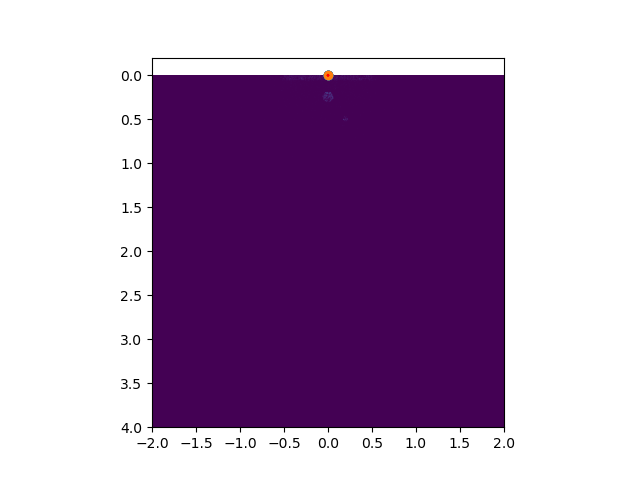

In [5]:
extent = -2, 2, 4, 0
plt.imshow(I_res[:,int(Ny/2),:].T, extent=extent)

In [6]:
x = np.arange(-0.00045+0.00000001,0.00045-0.00000001,0.00000001)
plt.plot(x,(-(cyls[0]-x)**2+cyls[2]**2)**0.5+cyls[1], color = 'r')
plt.plot(x,-(-(cyls[0]-x)**2+cyls[2]**2)**0.5+cyls[1], color = 'r')
plt.plot(x,(-(cyls[3]-x)**2+cyls[5]**2)**0.5+cyls[4], color = 'r')
plt.plot(x,-(-(cyls[3]-x)**2+cyls[5]**2)**0.5+cyls[4], color = 'r')
xl,xr,zd,zu = Bound_Far(cyls, Opt_prop(2)[3])
plt.scatter([xl, xr, xl, xr],[zu,zu,zd,zd])
plt.scatter([cyls[0]-cyls[2]-np.percentile(-np.log(np.random.random(100000))/Opt_prop(2)[3], 99.)],[0.])

C:\Users\nikom\AppData\Local\Temp\ipykernel_9164\3274763578.py:2: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x,(-(cyls[0]-x)**2+cyls[2]**2)**0.5+cyls[1], color = 'r')
C:\Users\nikom\AppData\Local\Temp\ipykernel_9164\3274763578.py:3: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x,-(-(cyls[0]-x)**2+cyls[2]**2)**0.5+cyls[1], color = 'r')
C:\Users\nikom\AppData\Local\Temp\ipykernel_9164\3274763578.py:4: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x,(-(cyls[3]-x)**2+cyls[5]**2)**0.5+cyls[4], color = 'r')
C:\Users\nikom\AppData\Local\Temp\ipykernel_9164\3274763578.py:5: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x,-(-(cyls[3]-x)**2+cyls[5]**2)**0.5+cyls[4], color = 'r')
